In [228]:
!git clone https://github.com/mahmoudan0s/Automated-Material-Stream-Identification-System-MSI-.git

fatal: destination path 'Automated-Material-Stream-Identification-System-MSI-' already exists and is not an empty directory.


In [229]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import data, exposure

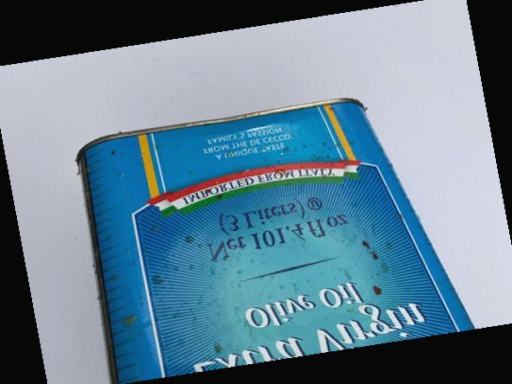

In [230]:
import cv2
from google.colab.patches import cv2_imshow

# Corrected img_path
img_path = "/content/Automated-Material-Stream-Identification-System-MSI-/data/split/train/metal/00d9085a-0f38-4dc2-b4ff-09a22cd0e7cd_aug00001.jpg"
img = cv2.imread(img_path)
cv2_imshow(img)

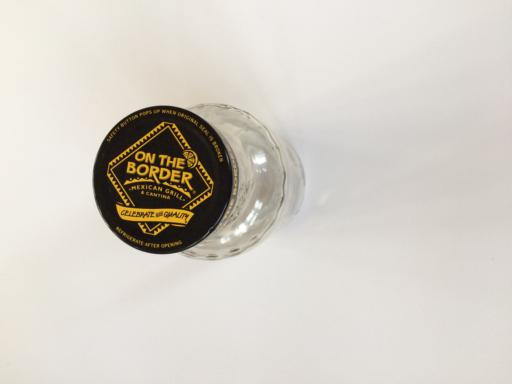

In [270]:
img_path_glass = "/content/Automated-Material-Stream-Identification-System-MSI-/data/split/train/glass/38f776d8-a398-46d8-ae80-269c7f03749d.jpg"
img_glass = cv2.imread(img_path_glass)
cv2_imshow(img_glass)

In [231]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [232]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [233]:
from torchvision import datasets, transforms

SVMtransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder("/content/Automated-Material-Stream-Identification-System-MSI-/data/split/train", transform=transform)
val_data  = datasets.ImageFolder("/content/Automated-Material-Stream-Identification-System-MSI-/data/split/val",  transform=transform)


In [234]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)


In [235]:
import torch
import torchvision.models as models
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.efficientnet_b0(weights="DEFAULT")
model.classifier = nn.Identity()   # remove final FC layer
model = model.to(device)
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [236]:
def extract_features(dataloader):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = model(imgs)
            feats = feats.cpu().numpy()

            features.append(feats)
            labels.append(lbls.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels


In [237]:
train_X, train_y = extract_features(train_loader)
val_X,   val_y   = extract_features(val_loader)

print(train_X.shape)  # (num_images, 1280)
print(val_X.shape)

(2705, 1280)
(273, 1280)


In [238]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_pca = pca.fit_transform(train_X)
val_pca = pca.transform(val_X)

In [239]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

SVM = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(train_X, train_y)

pred = svm.predict(val_X)
print("SVM Accuracy:", accuracy_score(val_y, pred))


SVM Accuracy: 0.9340659340659341


In [240]:
svm.fit(train_pca, train_y)
pred = svm.predict(val_pca)
print("SVM Accuracy:", accuracy_score(val_y, pred))

SVM Accuracy: 0.9304029304029304


In [241]:
linearSVM = SVC(kernel='linear', C=1)
linearSVM.fit(train_X, train_y)
pred = linearSVM.predict(val_X)
print("SVM Accuracy:", accuracy_score(val_y, pred))

SVM Accuracy: 0.8974358974358975


In [242]:
linearSVM.fit(train_pca, train_y)
pred = linearSVM.predict(val_pca)
print("SVM Accuracy:", accuracy_score(val_y, pred))

SVM Accuracy: 0.8681318681318682


In [243]:
KNNtransform = transforms.Compose([
  transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

KNNtrain_data = datasets.ImageFolder("/content/Automated-Material-Stream-Identification-System-MSI-/data/split/train", transform=KNNtransform)
KNNval_data  = datasets.ImageFolder("/content/Automated-Material-Stream-Identification-System-MSI-/data/split/val",  transform=KNNtransform)

In [244]:
KNNtrain_loader = DataLoader(KNNtrain_data, batch_size=32, shuffle=False)
KNNval_loader   = DataLoader(KNNval_data, batch_size=32, shuffle=False)

In [245]:
KNNtrain_X, KNNtrain_y = extract_features(KNNtrain_loader)
KNNval_X,   KNNval_y   = extract_features(KNNval_loader)

print(KNNtrain_X.shape)  # (num_images, 1280)
print(KNNval_X.shape)

(2705, 1280)
(273, 1280)


In [246]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
KNNtrain_X = scaler.fit_transform(KNNtrain_X)
KNNval_X = scaler.transform(KNNval_X)

In [264]:
from sklearn.decomposition import PCA

KNNpca = PCA(n_components=256)
KNNtrain_pca = pca.fit_transform(KNNtrain_X)
KNNval_pca = pca.transform(KNNval_X)

In [265]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='cosine',weights='distance')
knn.fit(KNNtrain_X, train_y)
knn_pred = knn.predict(KNNval_X)
print("KNN Accuracy:", accuracy_score(val_y, knn_pred))

KNN Accuracy: 0.8791208791208791


In [266]:
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine',weights='distance')
knn.fit(train_pca, train_y)
knn_pred = knn.predict(val_pca)
print("KNN Accuracy:", accuracy_score(val_y, knn_pred))

KNN Accuracy: 0.8901098901098901


In [269]:
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine',weights='distance')
knn.fit(KNNtrain_pca, train_y)
knn_pred = knn.predict(KNNval_pca)
print("KNN Accuracy:", accuracy_score(val_y, knn_pred))

KNN Accuracy: 0.8901098901098901
